# Merfish to visium registration

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import imp
import tools
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from ipykernel import kernelapp as app


<module 'tools' from '/ifshome/oamiuwu/STalign/tools.py'>

# Load atlas image

<IPython.core.display.Javascript object>


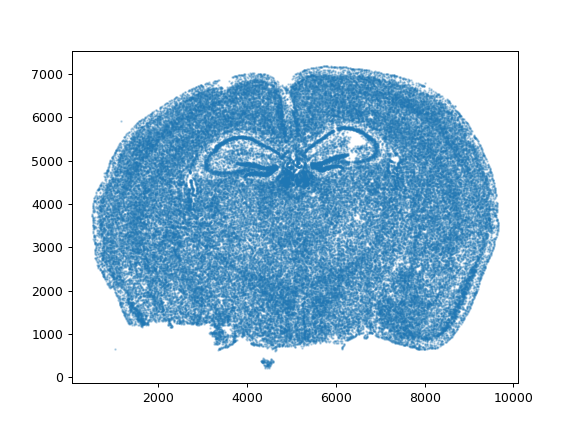

<IPython.core.display.Javascript object>


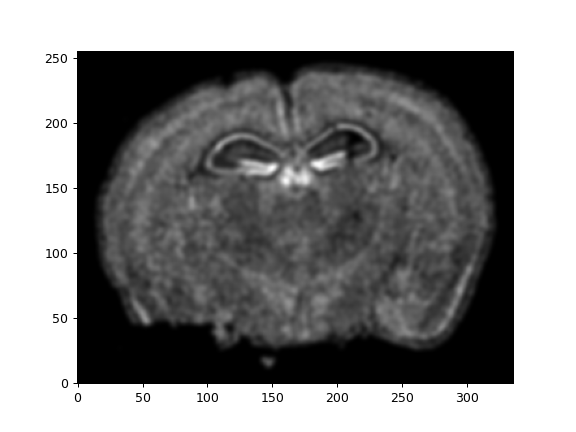

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [2]:
files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
fname = files[5]

df = pd.read_csv(fname)
xM = np.array(df['center_x'])
yM = np.array(df['center_y'])

fig,ax = plt.subplots()
ax.scatter(xM,yM,s=1,alpha=0.25)

X,Y,M,fig = tools.rasterize(xM,yM)
ax = fig.axes[0]

# Load target image

<IPython.core.display.Javascript object>


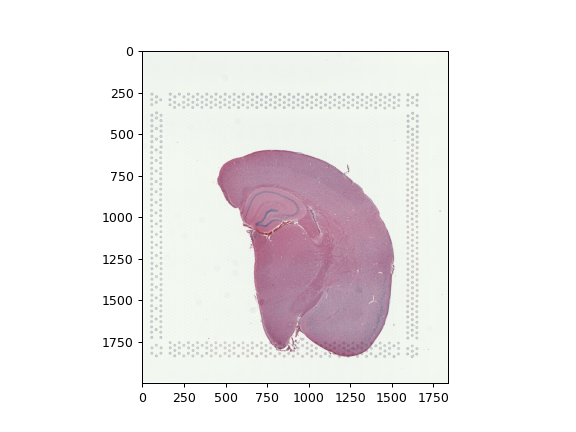

In [3]:
# visium
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_hires_image.png'
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_lowres_image.png'
visium_file = 'tissue_hires_image.png'
V = plt.imread(visium_file)
fig,ax = plt.subplots()
ax.imshow(V)

V = V.transpose(2,0,1)

# Declare landmark points and plot them

In [5]:
data = np.load('visium2_points.npz') #in x,y order
pointsI = np.array(data['pointsI'][...,::-1])
pointsJ = np.array(data['pointsJ'][...,::-1])

In [22]:
I = tools.normalize(M)
# note we multiply XI YI by 30, because the locations were
# recorded as pixel indices, and we rasterize at 30 micron resolution
YI = np.array(range(I.shape[1]))*30.
XI = np.array(range(I.shape[2]))*30.

J = tools.normalize(V).astype(I.dtype)
YJ = np.array(range(J.shape[1]))*1.
XJ = np.array(range(J.shape[2]))*1.

extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))

<IPython.core.display.Javascript object>


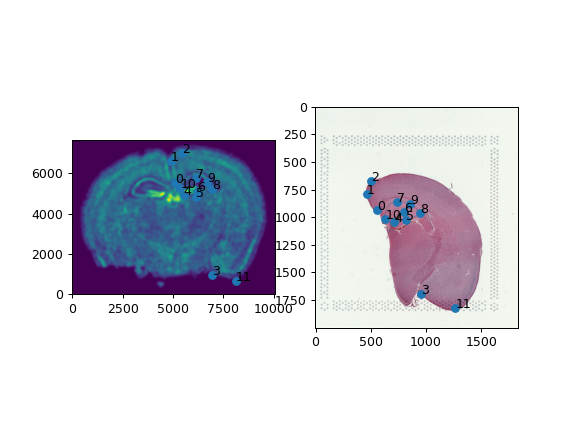

In [7]:
# let's place some landmarks and continue
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/I.max()).transpose(1,2,0), extent=extentI)
ax[1].imshow((J).transpose(1,2,0), extent=extentJ)

ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}')

# Run the mapping code

/nafs/dtward/torch_venv/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


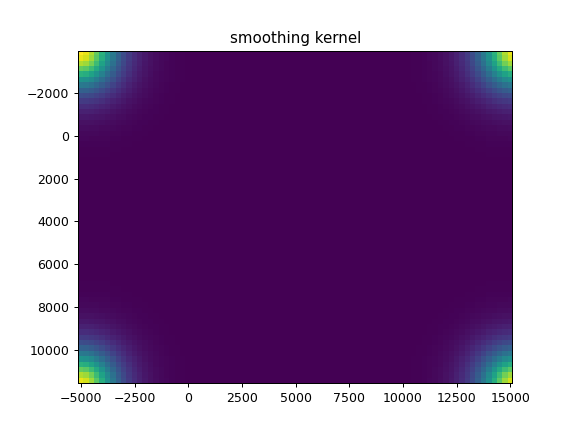

<IPython.core.display.Javascript object>


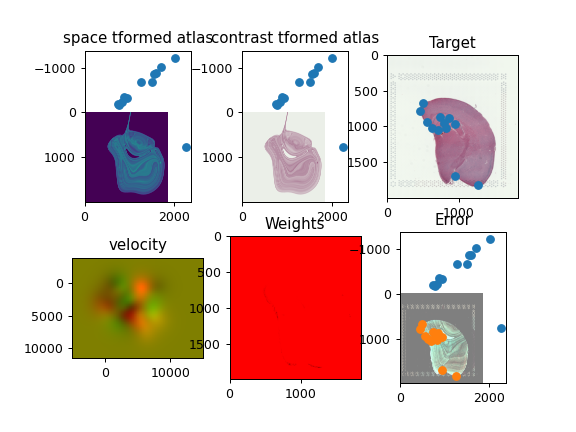

<IPython.core.display.Javascript object>


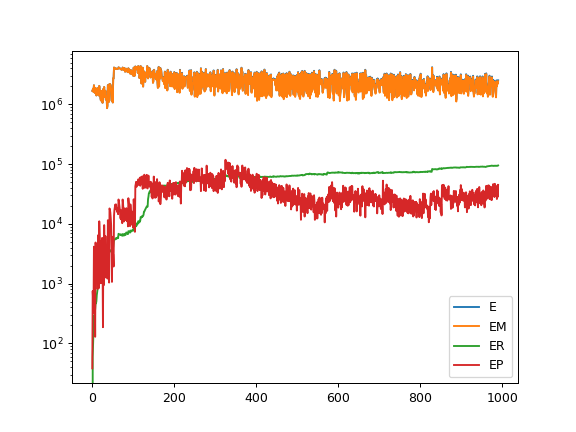

In [8]:
imp.reload(tools)
L,T = tools.L_T_from_points(pointsI,pointsJ)
device = 'cpu'
params = {'L':L,'T':T,
          'niter':1000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':0.2
          }

A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

# Apply transform to atlas image

<IPython.core.display.Javascript object>


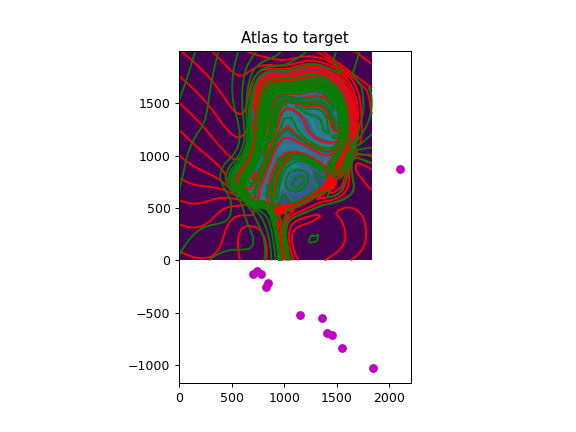

In [23]:
imp.reload(tools)
levels = np.arange(-100000,100000,1000)

fig,ax = plt.subplots()
phii = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = tools.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phipointsI = tools.transform_points_atlas_to_target(xv,v,A,pointsI)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Atlas to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phipointsI[:,1].detach(),phipointsI[:,0].detach(),c="m")

# Apply transform to target image

<IPython.core.display.Javascript object>


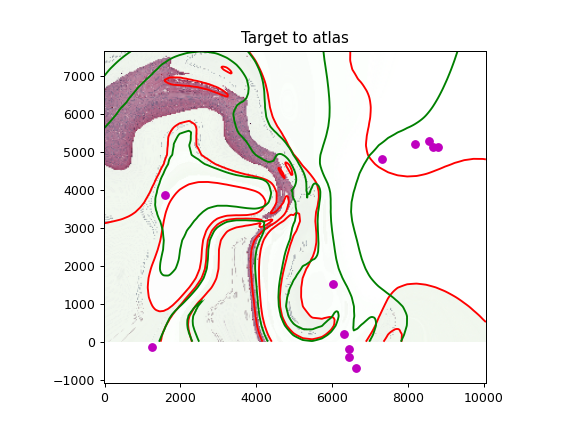

In [18]:
levels = np.arange(-100000,100000,1000)

fig,ax = plt.subplots()
phi = tools.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = tools.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,pointsJ)

ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Target to atlas')

ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")

1. sigmaM = 0.2, sigmaB=0.5, sigmaA=1
2. gradient descents all 0 (eV deformation and eL linear), but tweak eT translation
3. choose et, let eV be 0, tweak eL ...
4. tweak sigmaA, then sigmaB